# Embedding restrictions for simple feed forward networks

In [1]:
#%matplotlib widget

## Overview

[Kuehn, Kuntz] show that feed forward neural networks have embedding restrictions.
We implement simple examples.

**Example**: A classification of a classical inner and outer circle data set
- The shape of the data set encourages to learn a generalization function similar to $|x|^2$ as a continuous function from $\R^2 \to \R^1$.
- To achieve high accuracy, the NN should be topologically equivalent to $|x|^2$.
- But this would generate a minimum inside the decision boundary

**Outcome**:
We will observe that certain architectures fail to generate high accuracy despite a large amount of parameters due to the embedding restrictions

**Architectures**:
1. (Fully connected) feed forward NNs (FFNN) of 2d input with constant width 2 and 1d output
2. FFNNs with bottle neck: 1 layer of width 1 inbetween two layers of width 2
3. Shallow FFNNs with width 3
4. Note: ResNet architectures and neuralODEs will be investigated in separate file


It holds that FFNN of constant input dimension width and with full rank parameter matrices are not able to generate singular points $x^*$, i.e. a Jacobian w.r.t. the inputs that is the 0 matrix at $x^*$. As such, any NN of two dimensional input with layers of width two cannot generate an input to output function that is topologically equivalent to $|x|^2$.

It further holds that even a bottle neck, that is a sequence of 3 layers where the middle layer has a strictly smaller dimension, cannot generate a singular point either. As a result no FFNN with at maximum 2 neurons per layer can approximate $|x|^2$.

There will be


CONTINUE HERE BY ADDING THE TRAINING DATA FROM THE OTHER FILE TO THIS FILE SO IT WORKS. I Already added the test_dataloader to the other file which was not used before there. but here i want to use it for accuracy.


# Generating the data set

496
tensor([1])


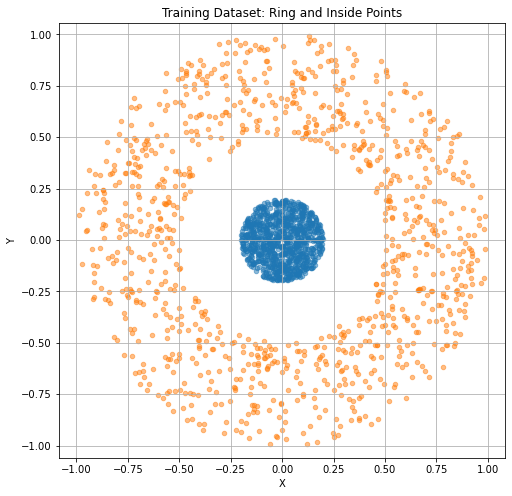

In [2]:
# 🧪 Imports and data prep
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from models.training import make_circles_uniform

# seed = 43
seed = np.random.randint(1000)
torch.manual_seed(seed)
np.random.seed(seed)


depth = 15 # Number of layers
cross_entropy = True
batch_size=128


train_loader, test_loader = make_circles_uniform(output_dim = 1., n_samples = 2000, inner_radius = 0.5, outer_radius = 1.0, buffer = 0.3, cross_entropy=True)


# Defining the feed forward neural network structure

In [3]:
class FFnet(nn.Module):
    def __init__(self, depth=depth, width=2, bottleneck=False, activation='tanh'):
        super().__init__()
        act_fn = nn.Tanh if activation == 'tanh' else nn.ReLU
        self.activations = []
        layers = []
        in_features = 2

        for i in range(depth):
            out_features = 1 if bottleneck and i == depth - 2 else width
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.BatchNorm1d(out_features))
            layers.append(act_fn())
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))  # output layer
        self.net = nn.Sequential(*layers)

    def forward(self, x, collect_activations=False):
        # Add a batch dimension if input is 1D
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Shape becomes [1, features]
        self.activations = []
        for layer in self.net[:-1]:
            x = layer(x)
            if collect_activations and isinstance(layer, (nn.Tanh, nn.ReLU)):
                self.activations.append(x.detach().cpu().numpy())
        x = self.net[-1](x)
        return torch.sigmoid(x)


In [4]:
def compute_accuracy(y_pred, y_true):
    """
    y_pred: float32 predictions (sigmoid outputs)
    y_true: float32 ground truth labels (0 or 1)
    """
    y_pred_binary = (y_pred >= 0.5).int()
    y_true_binary = y_true.int()
    correct = (y_pred_binary == y_true_binary).sum().item()
    total = y_true.shape[0]
    return correct / total

import copy

def train_model(model, train_loader, test_loader,
                                epochs=300, lr=0.01, patience=300, batch_size=128):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_acc = 0
    patience_counter = 0
    losses = []



    for epoch in range(epochs):
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss / len(train_loader))

        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            acc_summed = 0.
            counter = 0
            for X_test, y_test in test_loader:
                counter += 1
                test_preds = model(X_test)
                acc_summed += compute_accuracy(test_preds, y_test)
            acc = acc_summed / counter
        model.train()

        if acc > best_acc:
            best_acc = acc
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best acc: {best_acc:.3f}")
                break

        # At end, load the best model
    if patience_counter > 0:
        model.load_state_dict(best_model_state)

    return model, best_acc, losses  # <--- return the best model!



def train_until_threshold(model_class, train_loader, test_loader,
                          max_retries=10, threshold=0.95, **model_kwargs):
    for attempt in range(1, max_retries + 1):
        model = model_class(**model_kwargs)
        model, acc, losses = train_model(model, train_loader, test_loader)
        print(f"[Attempt {attempt}] Accuracy: {acc:.3f}")
        if acc >= threshold:
            print(f"✅ Success after {attempt} attempt(s)!")
            return model, acc, losses
    print("❌ Failed to reach threshold.")
    return model, acc, losses



In [5]:
def plot_loss_curve(losses, title="Training Loss"):
    plt.figure(figsize=(6, 4))
    plt.plot(losses, label="Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy Loss")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
from matplotlib.colors import to_rgb, LinearSegmentedColormap


def plot_decision_boundary(model, X, y, title="Decision Boundary", margin = 0.2):
    
    colors = [to_rgb("C0"), [1, 1, 1], to_rgb("C1")] # first color is orange, last is blue
    cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
    
    model.eval()
   
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)
    
    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, preds, levels=50, cmap=cm, alpha=0.8)
    # plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolors='k')
    plt.colorbar(label='Prediction Probability')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.scatter(X[:, 0], X[:, 1], s=25, c = y.squeeze(), cmap = cm, edgecolors='black', linewidths=0.5, alpha=0.9)
    # plt.scatter(inside_points[:500, 0], inside_points[:500, 1], s=25, c='C0',  edgecolors='black', linewidths=0.5, alpha=0.5,  label='Inside Points')
    plt.title(title)
    # plt.axis('equal')
    plt.grid(False)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axis('tight')
    plt.show()
    
    # model.eval()
    # x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    # y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    # xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
    #                      np.linspace(y_min, y_max, 200))
    # grid = np.c_[xx.ravel(), yy.ravel()]
    # grid_tensor = torch.tensor(grid, dtype=torch.float32)
    # with torch.no_grad():
    #     preds = model(grid_tensor).numpy().reshape(xx.shape)
    # plt.figure(figsize=(7, 6))
    # plt.contourf(xx, yy, preds, levels=50, cmap='coolwarm')
    # plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), cmap='bwr', edgecolors='k')
    # plt.title(title)
    # plt.xlabel("x₁")
    # plt.ylabel("x₂")
    # plt.colorbar()
    # plt.grid(True)
    # plt.show()


In [6]:
# Train both models
model_base, acc_base, losses_base = train_until_threshold(
    FFnet, train_loader, test_loader,
    max_retries=20, threshold=0.95,
    depth=15, width=2, bottleneck=False, activation='relu'
)

model_bottleneck, acc_bottleneck, losses_bottleneck = train_until_threshold(
    FFnet, train_loader, test_loader,
    max_retries=10, threshold=0.95,
    depth=15, width=2, bottleneck=True, activation='relu'
)


[Attempt 1] Accuracy: 0.880
[Attempt 2] Accuracy: 0.915
[Attempt 3] Accuracy: 0.830
[Attempt 4] Accuracy: 0.918
[Attempt 5] Accuracy: 0.962
✅ Success after 5 attempt(s)!
[Attempt 1] Accuracy: 0.947
[Attempt 2] Accuracy: 0.967
✅ Success after 2 attempt(s)!


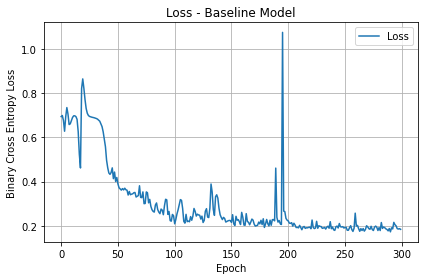

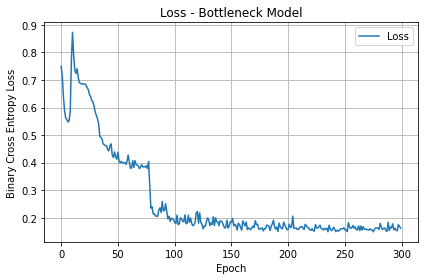

In [7]:
plot_loss_curve(losses_base, "Loss - Baseline Model")
plot_loss_curve(losses_bottleneck, "Loss - Bottleneck Model")


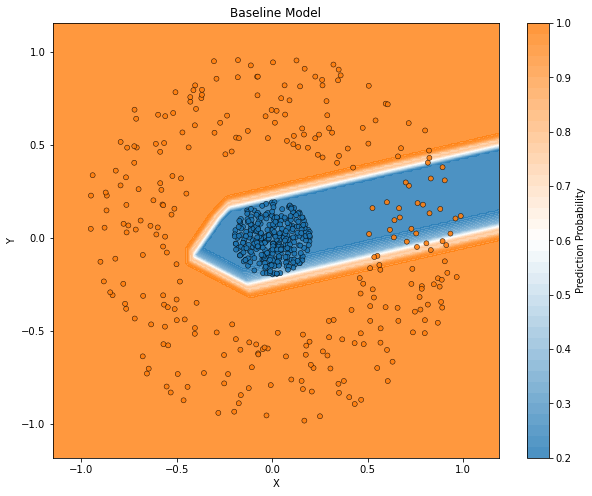

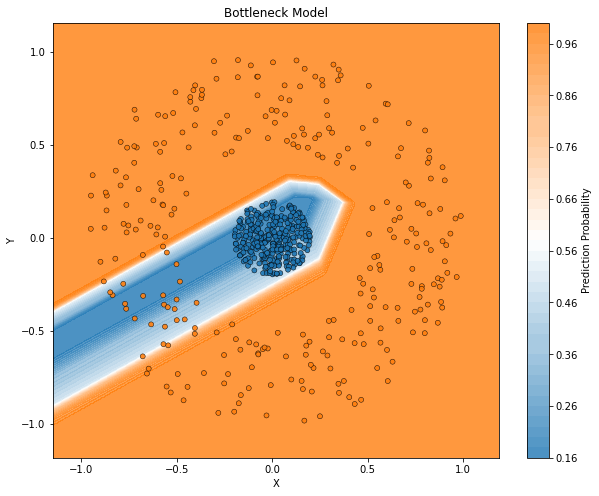

In [8]:

# Plot decision boundaries
X_test, y_test = next(iter(test_loader))

plot_decision_boundary(model_base, X_test.numpy(), y_test.numpy(), title="Baseline Model")
plot_decision_boundary(model_bottleneck, X_test.numpy(), y_test.numpy(), title="Bottleneck Model")



In [9]:
# from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
# from mpl_toolkits.mplot3d import axes3d
# from matplotlib import cm  # for colormaps

# def plot_decision_surface_3d(model, X, y, title="3D Prediction Surface"):
#     model.eval()
#     x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
#     y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
#                          np.linspace(y_min, y_max, 200))
#     grid = np.c_[xx.ravel(), yy.ravel()]
#     grid_tensor = torch.tensor(grid, dtype=torch.float32)

#     with torch.no_grad():
#         preds = model(grid_tensor).numpy().reshape(xx.shape)

#     fig = plt.figure(figsize=(12, 9))
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(xx, yy, preds, cmap=cm.coolwarm, edgecolor='none', alpha=0.9)

#     # Plot original data points in 3D (z=prediction)
#     with torch.no_grad():
#         data_preds = model(torch.tensor(X, dtype=torch.float32)).numpy()

#     ax.scatter(X[:, 0], X[:, 1], data_preds, c=y.squeeze(), cmap='bwr', edgecolor='k', s=30)

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Prediction')
#     ax.set_title(title)
#     fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Prediction Value')
#     plt.tight_layout()
#     plt.show()


In [10]:
    # plot_decision_surface_3d(model_base, X_test.numpy(), y_test.numpy(), title="3D Decision Surface - Baseline Model")
    # plot_decision_surface_3d(model_bottleneck, X_test.numpy(), y_test.numpy(), title="3D Decision Surface - Bottleneck Model")

The tunnels of blue class prediction values through the orange outer area is evidence of the embedding restrictions. Through more layers it is possible, that the tunnel gets narrower and narrower (further improving accuracy) but due to the embedding restictions, it cannot disappear.

## plot SVs

I am wondering if bottle necks improve training or if high accuracy correlates with SVs in some way

In [11]:


def plot_singular_values_of_weightmatrix(model, log_scale = True, title=''):
    """
    For each Linear layer in the model, compute the singular values using torch.svd,
    and plot them by layer index (x-axis) vs. singular value (y-axis).
    This version ensures all singular values are visible and x-ticks align with integer layer indices.
    """
    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    all_singular_values = []
    max_sv = float('-inf')
    min_sv = float('inf')

    for i, layer in enumerate(linear_layers):
        W = layer.weight.detach().cpu()
        try:
            _, S, _ = torch.svd(W)
            sv_numpy = S.numpy()
            all_singular_values.append((i, sv_numpy))
            max_sv = max(max_sv, sv_numpy.max())
            min_sv = min(min_sv, sv_numpy.min())
        except RuntimeError:
            print(f"⚠️ torch.svd failed on Layer {i+1} — possibly due to singularity.")
            all_singular_values.append((i, []))

    # Plot each singular value as a separate point per layer
    plt.figure()
    for layer_idx, svals in all_singular_values:
        for sv in svals:
            plt.scatter(layer_idx, sv, color='blue', alpha=0.4)

    plt.title("SVs: " + title)
    plt.xlabel("Layer Index")
    plt.ylabel("Singular Value (log scale)")
    if log_scale:
        plt.yscale("log")

    # Ensure y-axis covers all singular values
    y_max = max_sv * 1.2
    plt.ylim([1e-4, y_max])

    # Use integer x-ticks only for layer indices
    layer_indices = list(range(len(linear_layers)))
    plt.xticks(layer_indices)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()




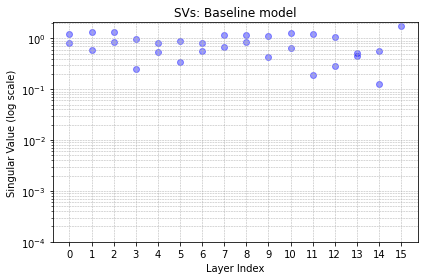

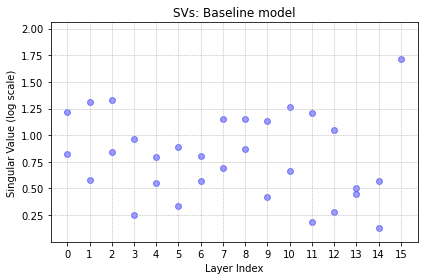

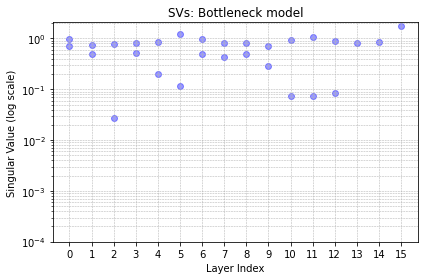

In [12]:

# Plot activation heatmaps
plot_singular_values_of_weightmatrix(model_base, title = 'Baseline model')
plot_singular_values_of_weightmatrix(model_base, log_scale=False, title = 'Baseline model')
plot_singular_values_of_weightmatrix(model_bottleneck, title = 'Bottleneck model')



## Train wide model

Models with augmented width have no embedding restrictions and we can observe that a singular value close to the origin is constructed almost immediatly

In [13]:
def plot_weight_heatmaps(model, title=''):
    import matplotlib.pyplot as plt
    import numpy as np
    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    n_layers = len(linear_layers)
    if n_layers == 0:
        print("No Linear layers with parameters found.")
        return

    fig, axes = plt.subplots(1, n_layers, figsize=(3 * n_layers, 3), squeeze=False)
    axes = axes[0]

    for i, layer in enumerate(linear_layers):
        weight = layer.weight.detach().cpu().numpy()
        weight = abs(weight)
        ax = axes[i]
        im = ax.imshow(weight, cmap='viridis', vmin = 0, vmax = 5, aspect='equal')

        ax.set_title(f"Layer {i}")
        ax.set_xlabel("Out")
        ax.set_ylabel("In")
       

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle("Weight Matrices Heatmaps - " + title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [24]:
model_wide, acc_wide, losses_wide = train_until_threshold(
    FFnet, train_loader, test_loader,
    max_retries=20, threshold=0.95,
    depth=1, width=3, bottleneck=False, activation='relu'
)

[Attempt 1] Accuracy: 1.000
✅ Success after 1 attempt(s)!


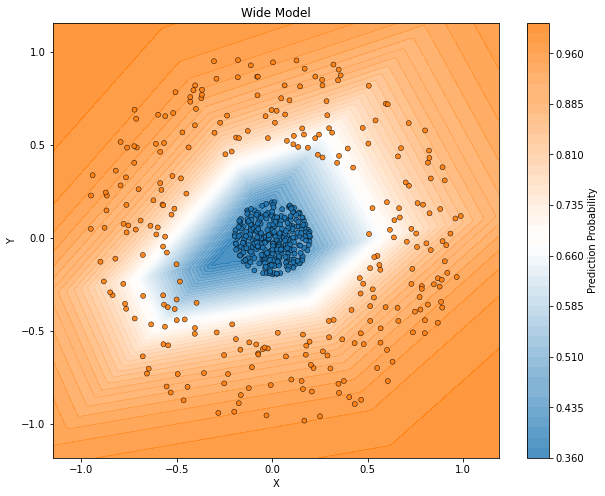

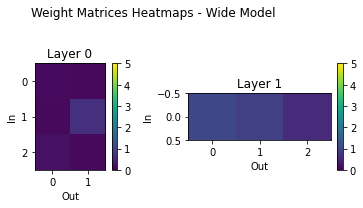

In [25]:
plot_decision_boundary(model_wide, X_test.numpy(), y_test.numpy(), title="Wide Model")
plot_weight_heatmaps(model_wide, title="Wide Model")

The heatmap of the layer 1 shows that the inner shape is constructed by almost equally including the 3 different neurons of the 0th layer creating a smoothed out triangle shape

In [16]:
# Define a grid over the input space.
grid_size = 100 # Adjust as needed.

def psi_manual(x, func):
    """
    x: a tensor of shape (2,) representing a point in R^2.
    model: a function mapping R^2 to R^2.
    
    Returns:
      The smallest singular value of the Jacobian of model at x.
    """
    # Ensure x is a leaf variable with gradient tracking enabled.
    x = x.clone().detach().requires_grad_(True)
    
    # Define a lambda function to ensure accurate input-output mapping
    # func = lambda inp: model(inp, output_layer = False)
    
    # Compute the Jacobian using torch.autograd.functional.jacobian (compatible with Python 3.8)
    jacobian = torch.autograd.functional.jacobian(func, x, create_graph=True)
    
    # Compute singular values using svdvals (available in PyTorch 1.8, compatible with Python 3.8)
    singular_values = torch.svd(jacobian, compute_uv=False)[1]
    
   
    return singular_values.detach().numpy()



x_range = np.linspace(-2, 2, grid_size)
y_range = np.linspace(-2, 2, grid_size)
psi_values = np.zeros((grid_size, grid_size, 2))

# Put the model in evaluation mode.
model_wide.eval()
func = lambda inp: model_wide(inp)



# Evaluate psi(x) over the grid.
for i, xv in enumerate(x_range):
    for j, yv in enumerate(y_range):
        # Create a 2D point as a torch tensor.
        x_point = torch.tensor([xv, yv], dtype=torch.float32)
        psi_values[j, i,:] = psi_manual(x_point, func) #one subtlety here: if there is only one SV it gets broadcast to all dimensions of psi_values[j,i,:] in the last dimension. this reduces if statements for e.g. the last layer, but we need to notice that the SINGLE SV gets plotted twice 

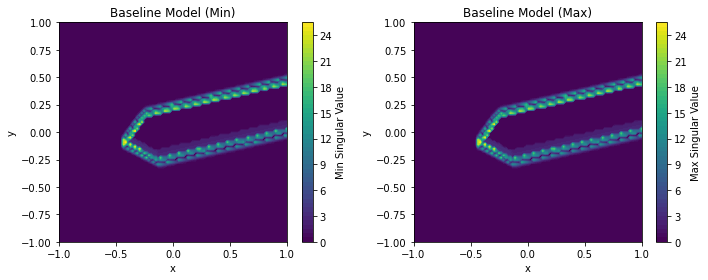

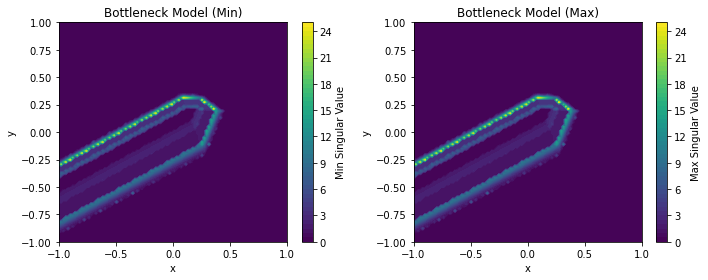

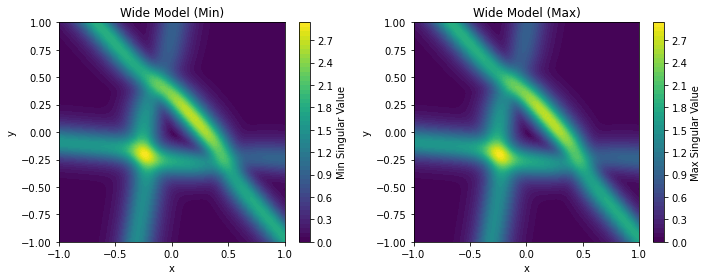

In [17]:
def compute_singular_values_grid(model, grid_size=200):
    x_range = np.linspace(-1, 1, grid_size)
    y_range = np.linspace(-1, 1, grid_size)
    psi_values = np.zeros((grid_size, grid_size, 2))

    model.eval()
    func = lambda inp: model(inp)

    for i, xv in enumerate(x_range):
        for j, yv in enumerate(y_range):
            x_point = torch.tensor([xv, yv], dtype=torch.float32)
            sv = psi_manual(x_point, func)

            # If only one singular value is returned (e.g., at the final layer), broadcast it
            if sv.shape[0] == 1:
                psi_values[j, i, :] = sv[0]
            else:
                psi_values[j, i, :] = sv
    return x_range, y_range, psi_values


def plot_singular_values(x_range, y_range, psi_values, title="Singular Values"):
    min_sv = psi_values[:, :, 0]
    max_sv = psi_values[:, :, 1]

    plt.figure(figsize=(10, 4))

    # Plot min singular value
    plt.subplot(1, 2, 1)
    plt.contourf(x_range, y_range, min_sv, levels=50, cmap='viridis')
    plt.colorbar(label='Min Singular Value')
    plt.title(f'{title} (Min)')
    plt.xlabel('x')
    plt.ylabel('y')

    # Plot max singular value
    plt.subplot(1, 2, 2)
    plt.contourf(x_range, y_range, max_sv, levels=50, cmap='viridis')
    plt.colorbar(label='Max Singular Value')
    plt.title(f'{title} (Max)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.tight_layout()
    plt.show()



models = [
    (model_base, "Baseline Model"),
    (model_bottleneck, "Bottleneck Model"),
    (model_wide, "Wide Model")
]

for model, name in models:
    x_range, y_range, psi_vals = compute_singular_values_grid(model, grid_size=100)
    plot_singular_values(x_range, y_range, psi_vals, title=name)


The SV plots show the very different structure of the NNs with 2 neurons per layer and the one with 3 neurons.

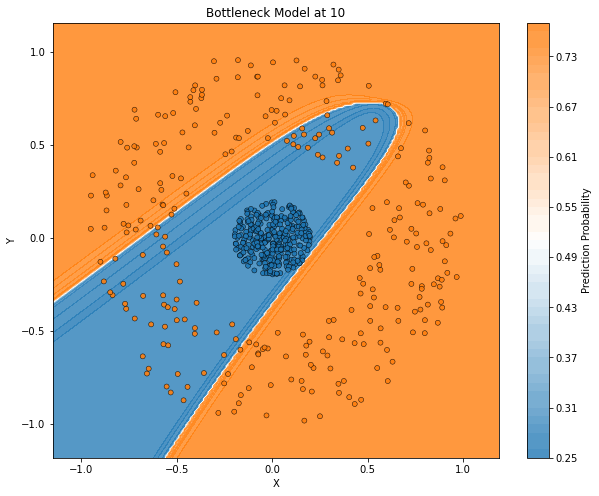

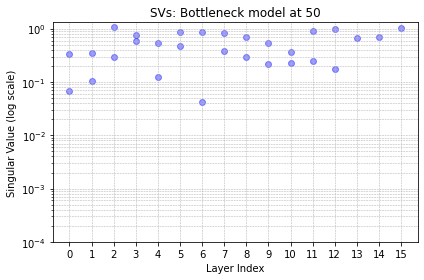

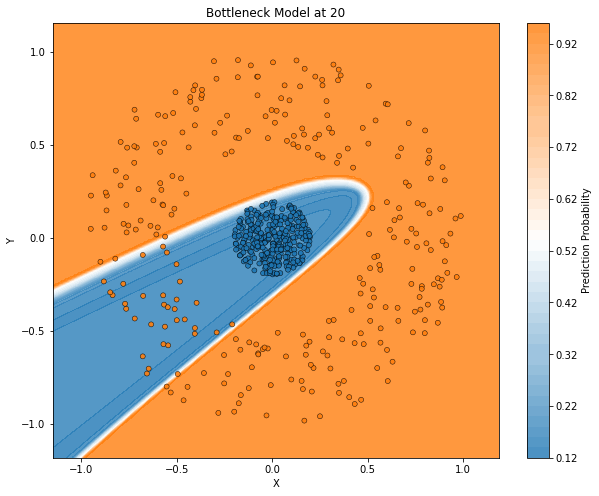

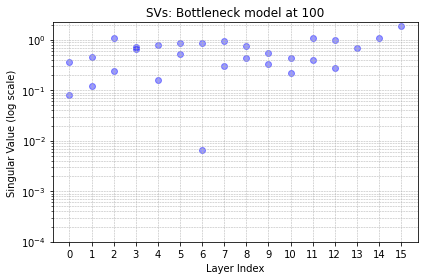

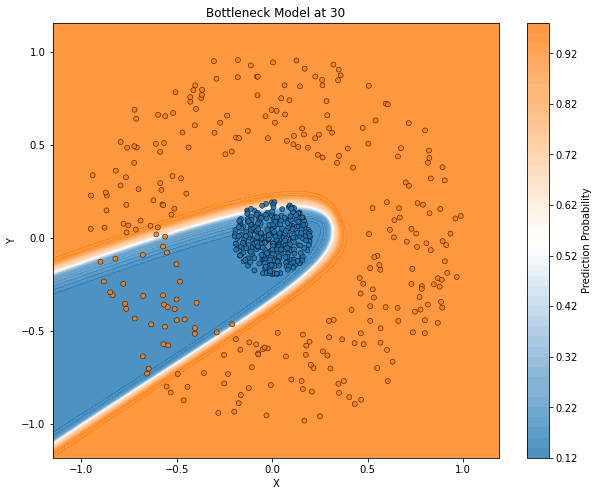

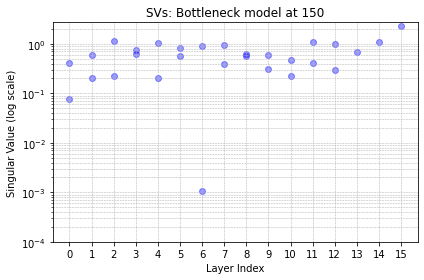

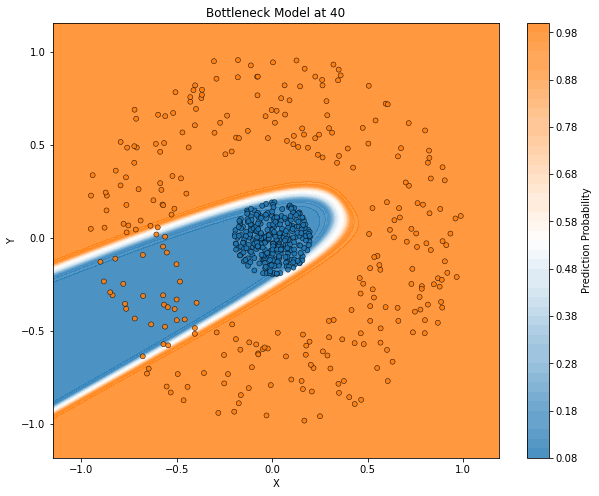

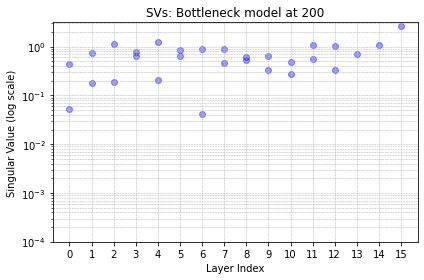

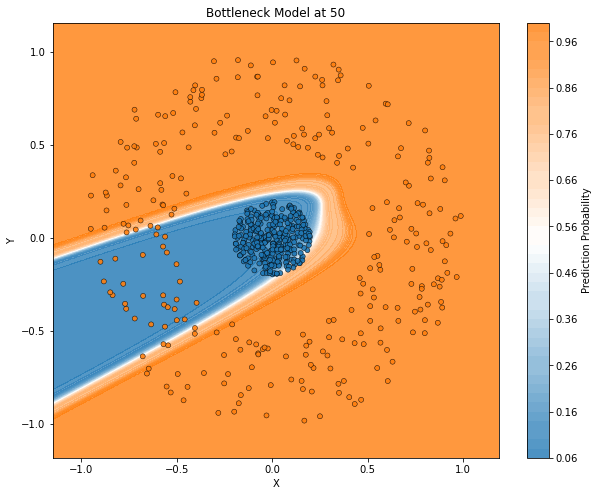

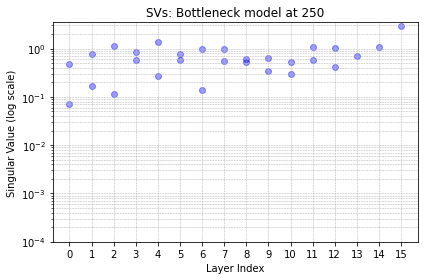

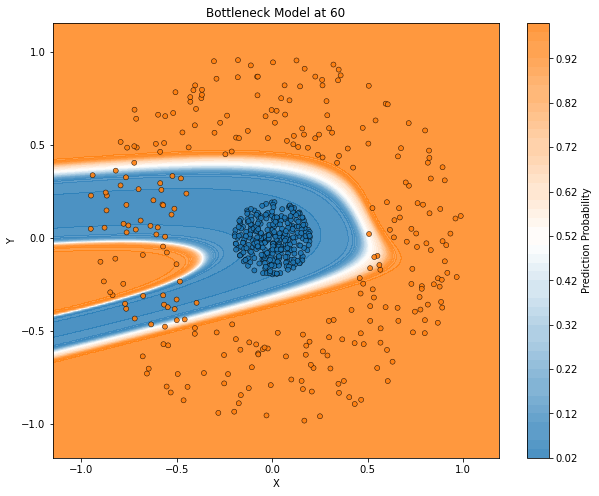

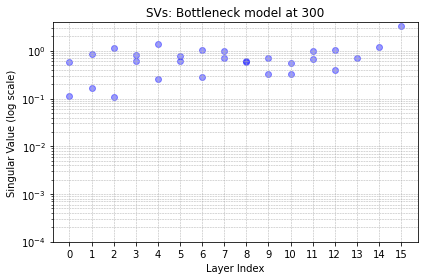

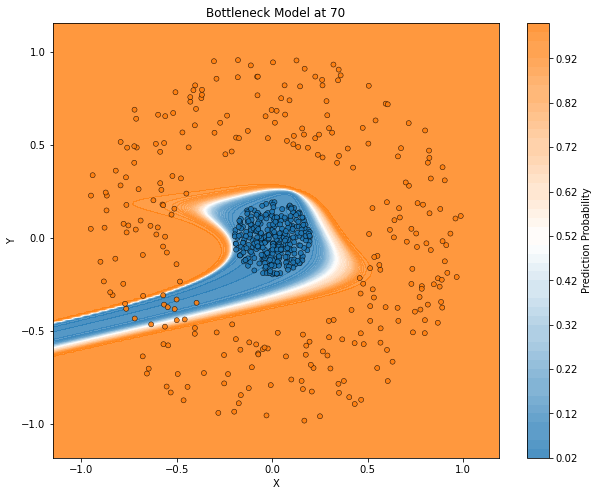

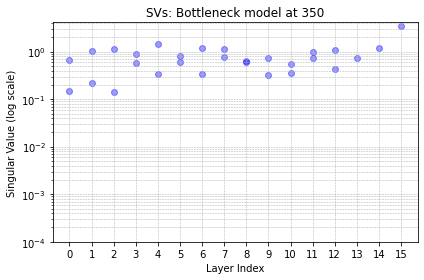

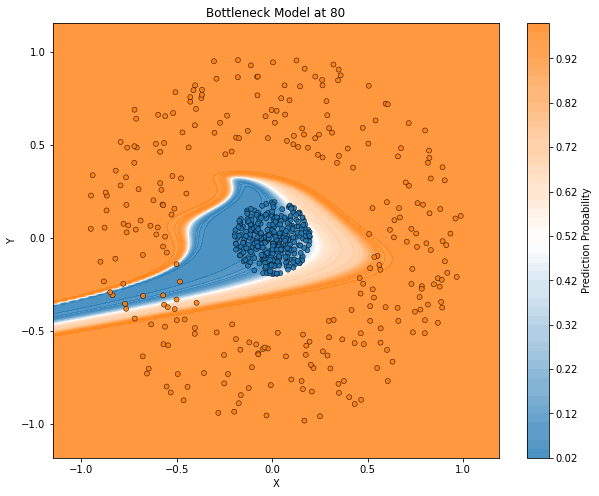

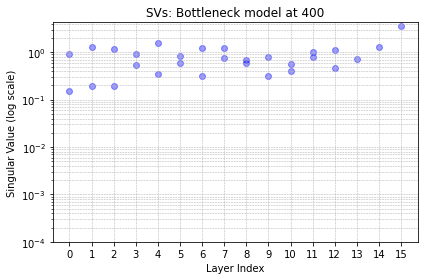

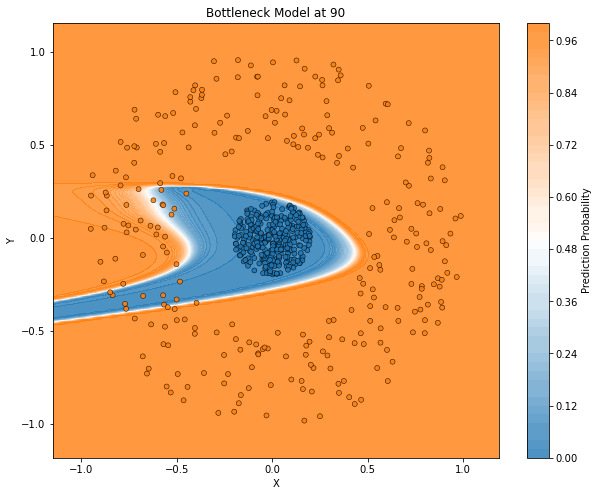

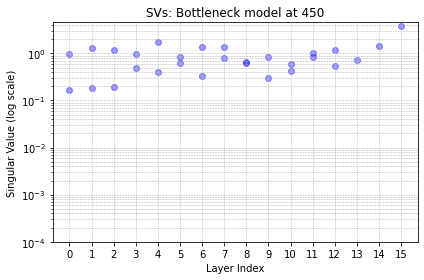

In [18]:
model_test = FFnet(depth=15, width=2, bottleneck=True, activation='tanh')
epoch_step = 10
losses_combined = []

for plot in range(1,10):
    _, _, losses_running = train_model(model_test, train_loader, test_loader,
                epochs=epoch_step, lr=0.01, patience=300, batch_size=128)
    plot_decision_boundary(model_test, X_test.numpy(), y_test.numpy(), title="Bottleneck Model at " + str(epoch_step*plot))
    plot_singular_values_of_weightmatrix(model_test, title = 'Bottleneck model at ' + str(50*plot))
    for loss in losses_running:
        losses_combined.append(loss)
    
    

[0.6975464875047858, 0.6786374720660123, 0.6097227768464522, 0.5255788293751803, 0.46574412421746686, 0.4092449870976535, 0.37016988613388757, 0.376525263894688, 0.3333763127977198, 0.3296370899135416, 0.41339675946669147, 0.39384306289932947, 0.37075606801293115, 0.3516330989924344, 0.29156522723761474, 0.30232434652068396, 0.2974932965907184, 0.31614625318483874, 0.287699817256494, 0.29750543561848725, 0.2779365209015933, 0.25550514459609985, 0.2522150765765797, 0.2437554435296492, 0.24405723268335516, 0.24145001037554306, 0.24390657517043027, 0.23349782147190787, 0.22738300534811887, 0.22951517728242007, 0.24176739969036795, 0.23308625681833786, 0.2537110982970758, 0.25353406234221026, 0.23492653667926788, 0.22203125736930154, 0.22227323190732437, 0.23379824378273703, 0.215623985637318, 0.2161948023871942, 0.25406225432049145, 0.23146174103021622, 0.21028573404658923, 0.18565211716023358, 0.1724354855038903, 0.20480418476191434, 0.16894519532268698, 0.21402668817476792, 0.1985452229

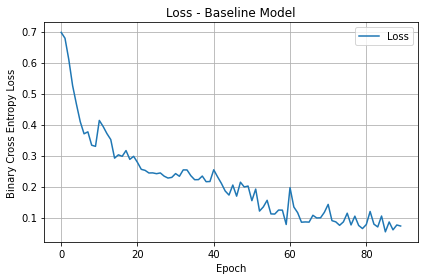

In [19]:
print(losses_combined)
plot_loss_curve(losses_combined, "Loss - Baseline Model")

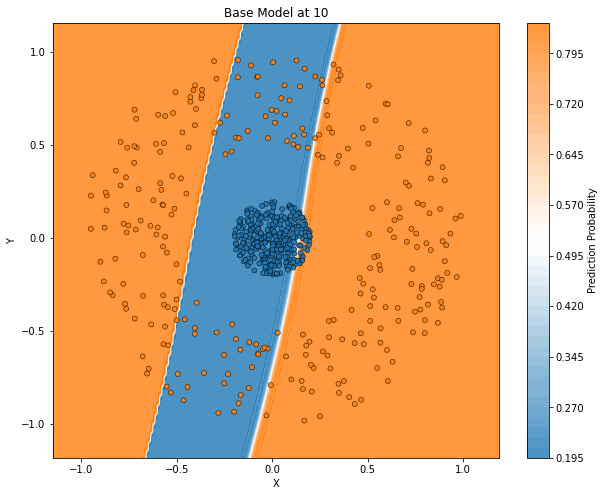

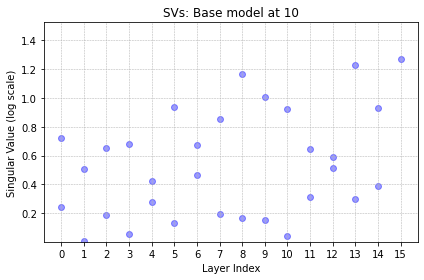

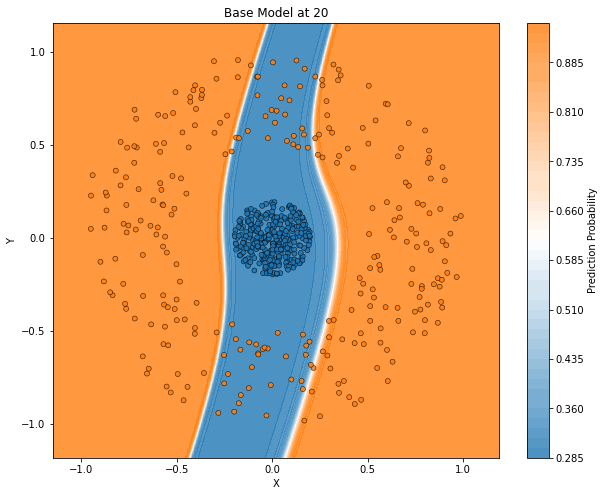

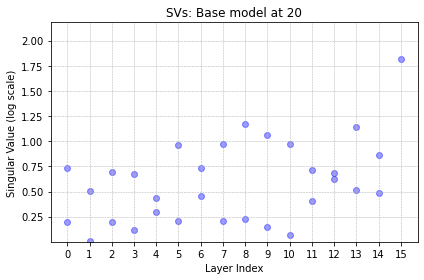

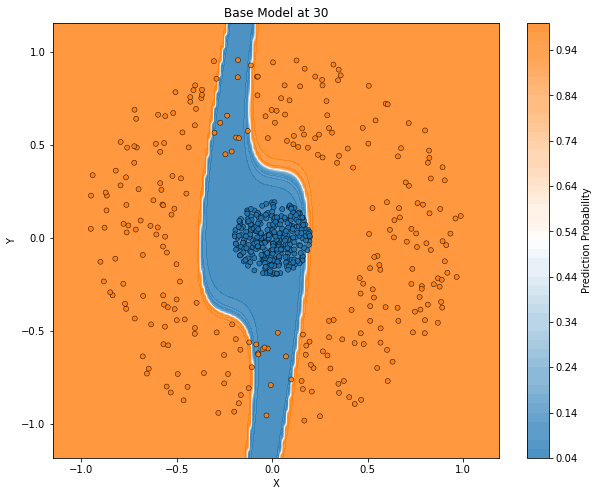

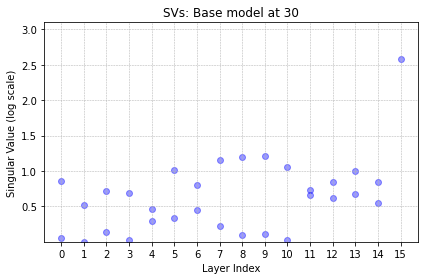

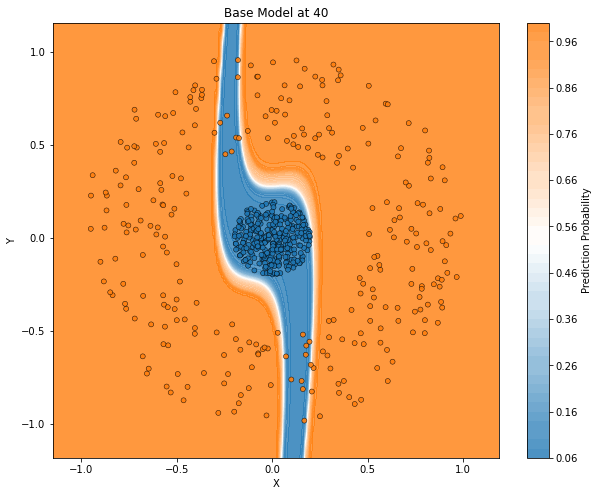

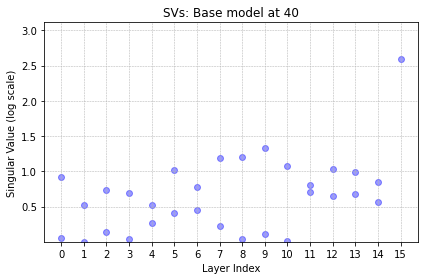

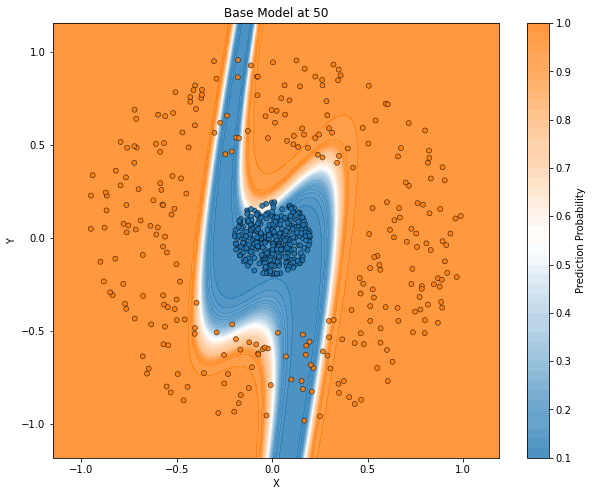

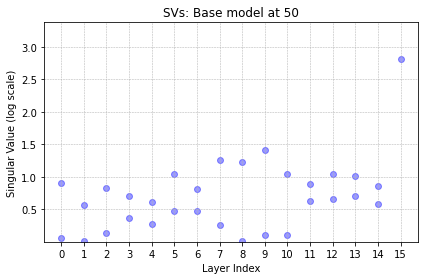

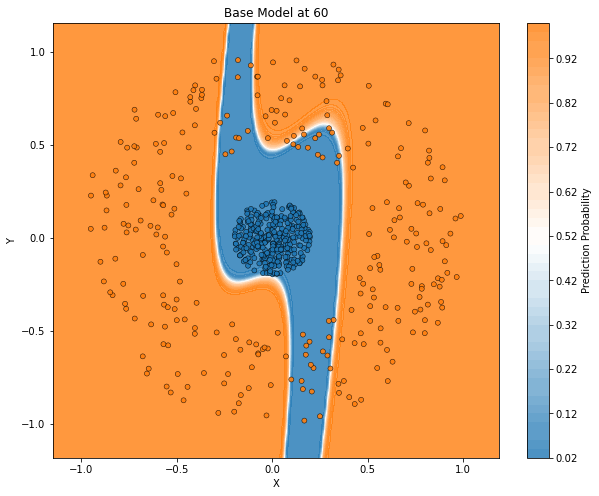

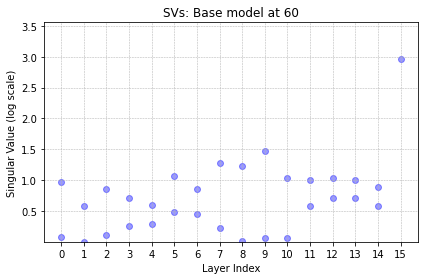

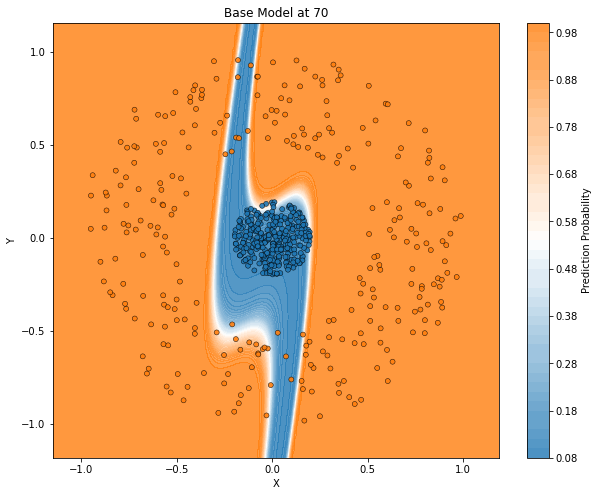

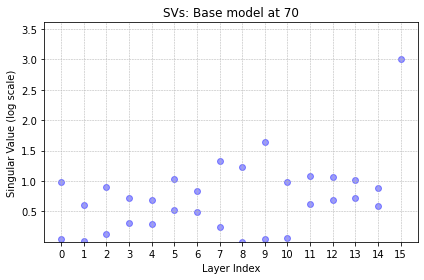

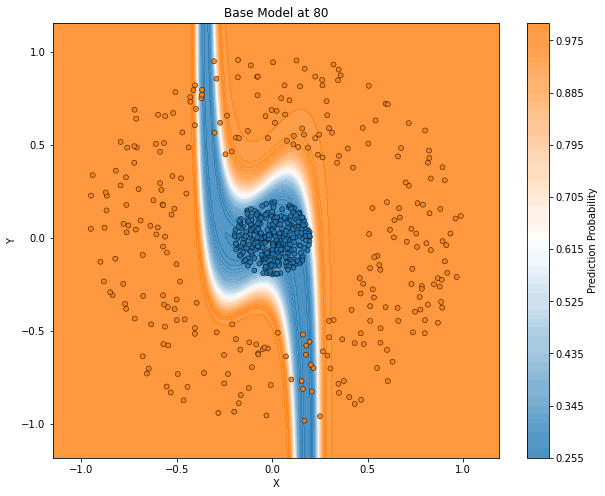

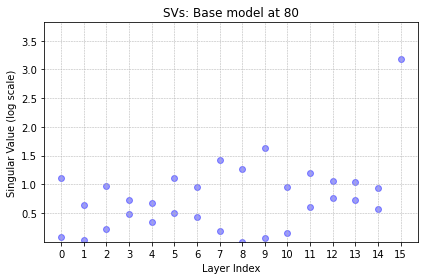

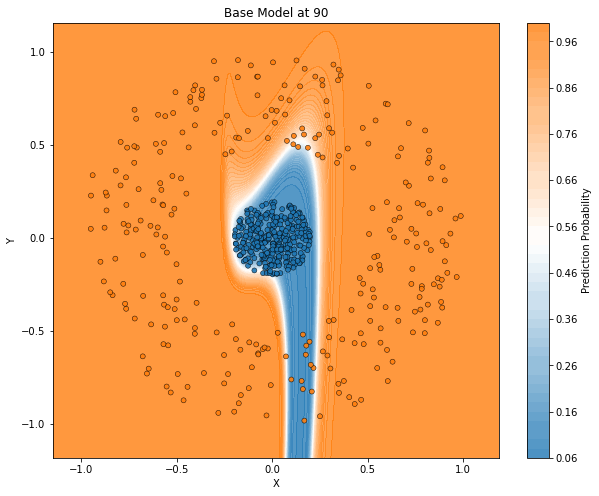

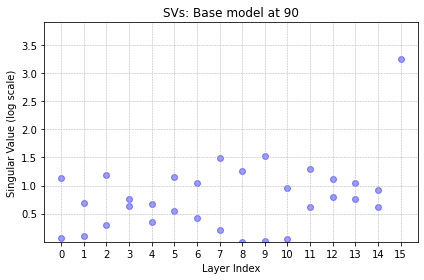

In [20]:
model_test = FFnet(depth=15, width=2, bottleneck=False, activation='tanh')
epoch_step = 10
losses_combined = []

for plot in range(1,10):
    _, _, losses_running = train_model(model_test, train_loader, test_loader,
                epochs=epoch_step, lr=0.01, patience=300, batch_size=128)
    plot_decision_boundary(model_test, X_test.numpy(), y_test.numpy(), title="Base Model at " + str(epoch_step*plot))
    plot_singular_values_of_weightmatrix(model_test, log_scale=False, title = 'Base model at ' + str(epoch_step*plot))
    for loss in losses_running:
        losses_combined.append(loss)
    
    

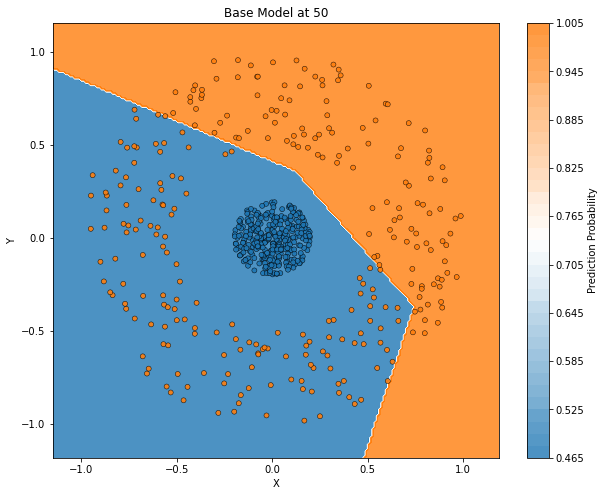

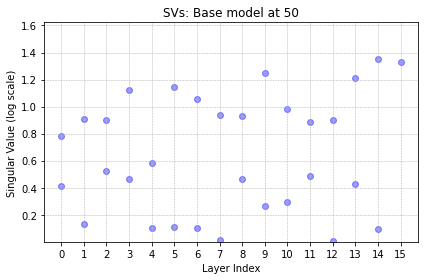

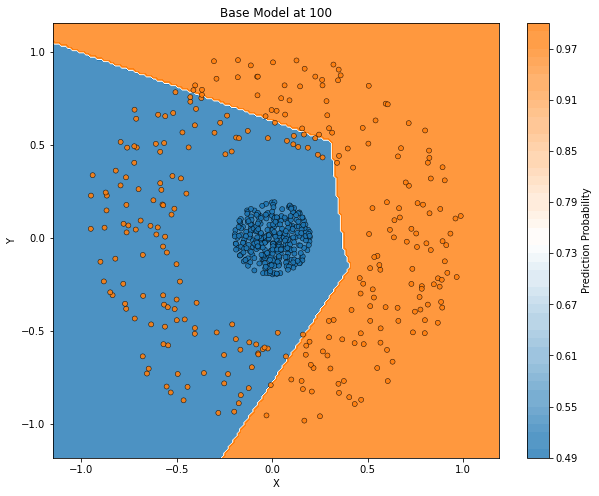

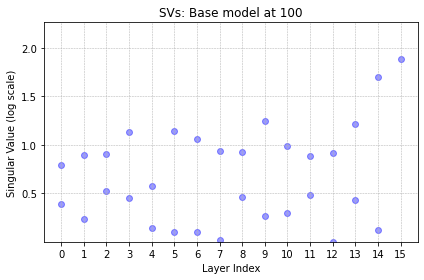

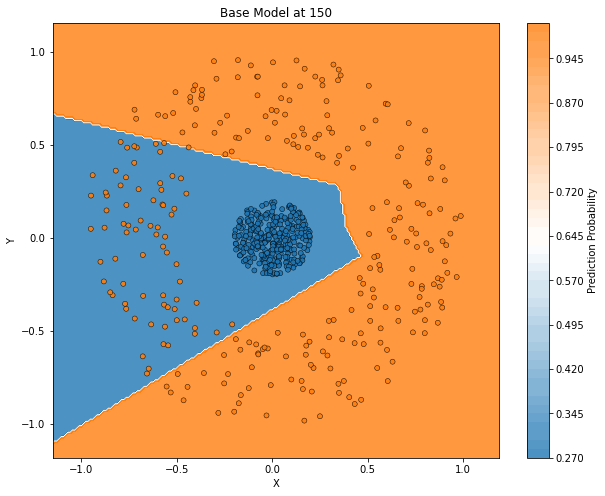

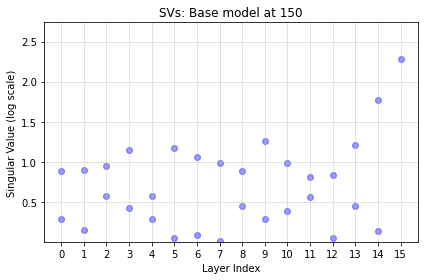

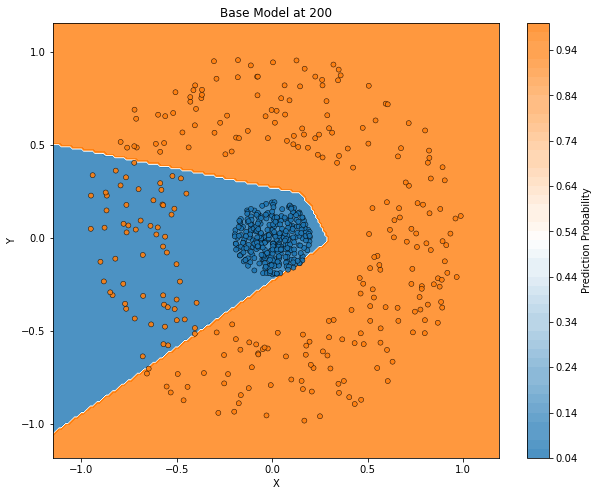

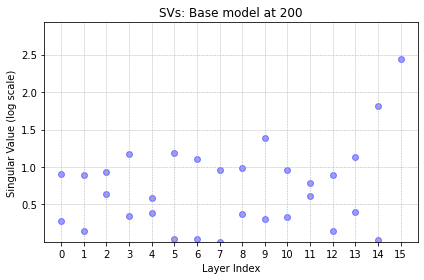

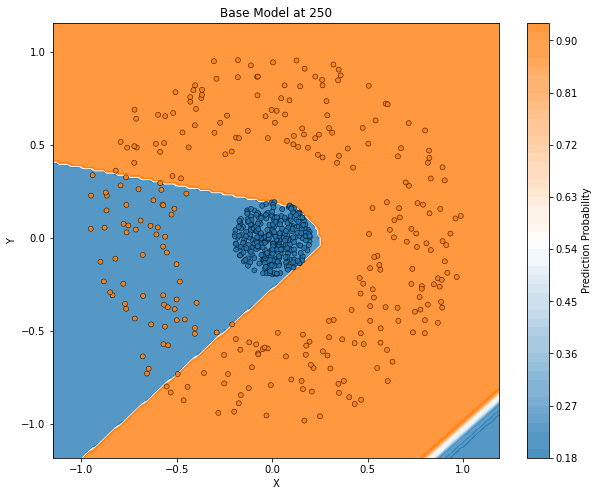

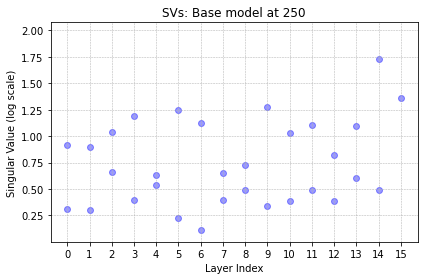

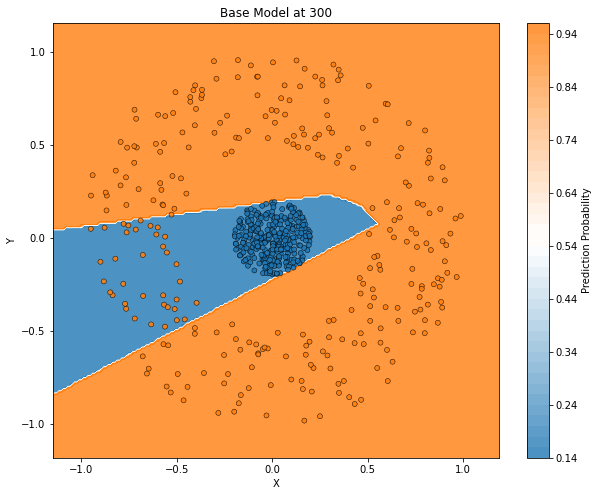

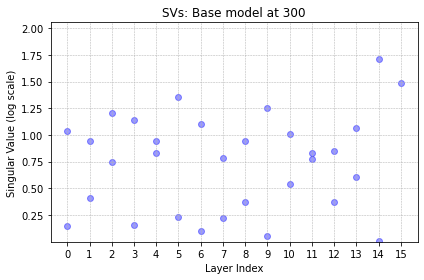

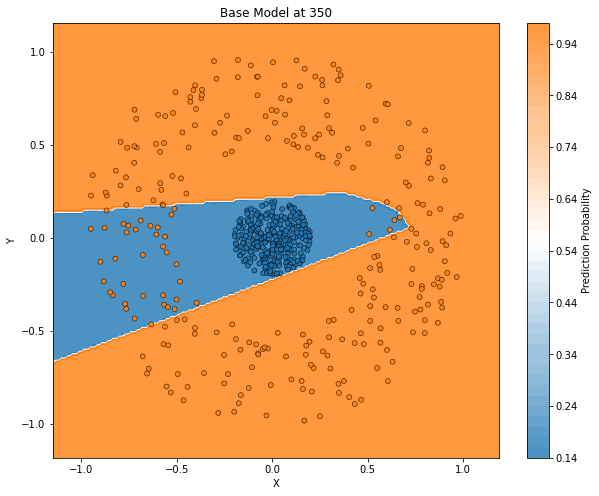

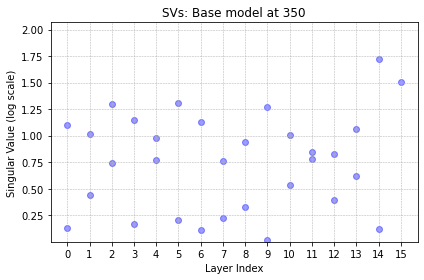

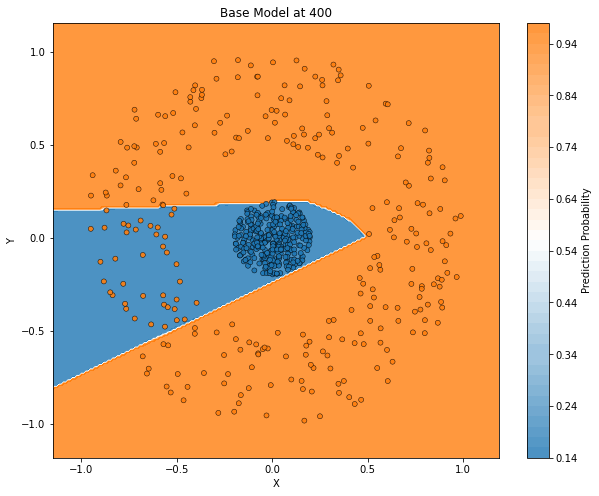

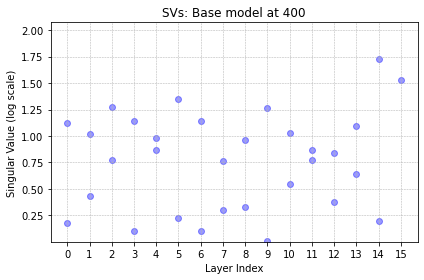

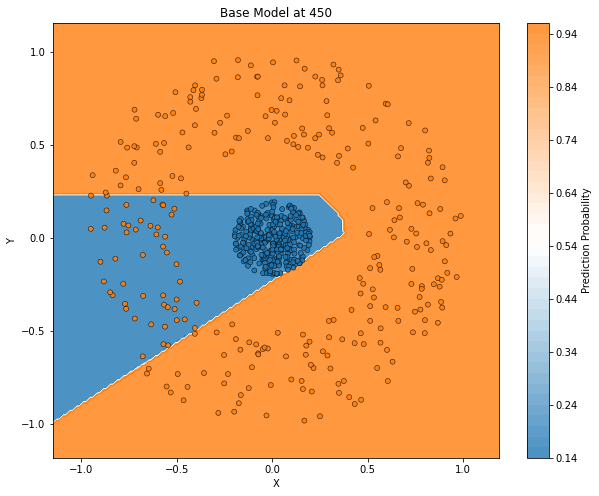

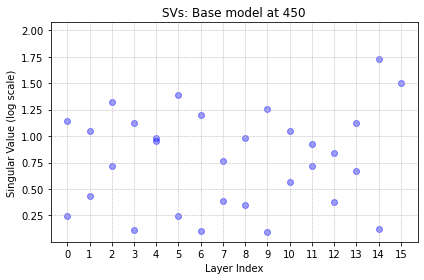

In [21]:
model_relu = FFnet(depth=15, width=2, bottleneck=False, activation='relu')
epoch_step = 50
losses_combined = []

for plot in range(1,10):
    _, _, losses_running = train_model(model_relu, train_loader, test_loader,
                epochs=epoch_step, lr=0.01, patience=300, batch_size=128)
    plot_decision_boundary(model_relu, X_test.numpy(), y_test.numpy(), title="Base Model at " + str(epoch_step*plot))
    plot_singular_values_of_weightmatrix(model_relu, log_scale=False, title = 'Base model at ' + str(epoch_step*plot))
    for loss in losses_running:
        losses_combined.append(loss)